# Heart Disease Prediction ML Pipeline

This notebook implements a complete machine learning pipeline for heart disease prediction using the UCI Heart Disease dataset. The pipeline includes data loading, preprocessing, feature engineering, model training, evaluation, and prediction capabilities.

## 1. Import Required Libraries

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Machine Learning libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Database libraries
import os
from sqlalchemy import create_engine, Column, Integer, Float, String, DateTime, Text, Boolean
from sqlalchemy.orm import declarative_base, sessionmaker
from datetime import datetime
import json

# Utility libraries
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

## 2. Database Setup (Optional)

Setup database schema for experiment tracking and prediction logging.

In [2]:
# Database setup
Base = declarative_base()

class ExperimentRun(Base):
    __tablename__ = 'experiment_runs'
    
    id = Column(Integer, primary_key=True)
    timestamp = Column(DateTime, default=datetime.utcnow)
    dataset_samples = Column(Integer)
    train_samples = Column(Integer)
    val_samples = Column(Integer)
    test_samples = Column(Integer)
    val_accuracy = Column(Float)
    test_accuracy = Column(Float)
    model_params = Column(Text)  # JSON string
    feature_importance = Column(Text)  # JSON string

class Prediction(Base):
    __tablename__ = 'predictions'
    
    id = Column(Integer, primary_key=True)
    timestamp = Column(DateTime, default=datetime.utcnow)
    experiment_id = Column(Integer)
    input_features = Column(Text)  # JSON string
    predicted_class = Column(Integer)
    prediction_probability = Column(Float)
    true_label = Column(Integer, nullable=True)
    is_correct = Column(Boolean, nullable=True)

def init_database():
    """Initialize database connection and create tables"""
    try:
        database_url = os.getenv('DATABASE_URL')
        if not database_url:
            print("Database URL not found. Skipping database setup.")
            return None
        
        engine = create_engine(database_url)
        Base.metadata.create_all(engine)
        Session = sessionmaker(bind=engine)
        return Session()
    except Exception as e:
        print(f"Database connection failed: {str(e)}")
        return None

# Initialize database session
db_session = init_database()

Database URL not found. Skipping database setup.


## 3. Data Loading and Overview

Load the Heart Disease dataset from UCI ML Repository and display basic information.

In [3]:
def load_dataset():
    """Load the Heart Disease dataset from UCI ML Repository"""
    try:
        from ucimlrepo import fetch_ucirepo
        
        print("Loading Heart Disease dataset from UCI ML Repository...")
        heart_disease = fetch_ucirepo(id=45)
        X = heart_disease.data.features
        y = heart_disease.data.targets
        
        # Combine features and target into a single DataFrame
        df = X.copy()
        df['target'] = y
        
        print("✅ Dataset loaded successfully!")
        return df, heart_disease
    except Exception as e:
        print(f"❌ Error loading dataset: {str(e)}")
        print("💡 Make sure you have the 'ucimlrepo' package installed: pip install ucimlrepo")
        return None, None

# Load the dataset
df, heart_disease_info = load_dataset()

if df is not None:
    print(f"\nDataset shape: {df.shape}")
    print(f"Features: {df.shape[1] - 1}")
    print(f"Samples: {df.shape[0]}")
    print(f"Target classes: {df['target'].nunique()}")
    print(f"Missing values: {df.isnull().sum().sum()}")

Loading Heart Disease dataset from UCI ML Repository...
✅ Dataset loaded successfully!

Dataset shape: (303, 14)
Features: 13
Samples: 303
Target classes: 5
Missing values: 6


In [4]:
# Display first few rows
if df is not None:
    print("First 5 rows of the dataset:")
    display(df.head())
    
    print("\nDataset info:")
    df.info()

First 5 rows of the dataset:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0



Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  target    303 non-null    int64  
dtypes: float64(3), int64(11)
memory usage: 33.3 KB


## 4. Descriptive Statistics and Data Exploration

Analyze the dataset characteristics and visualize the data distribution.

In [5]:
if df is not None:
    # Basic statistics
    print("Numerical Features Statistics:")
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    display(df[numeric_cols].describe())

Numerical Features Statistics:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,299.000000,301.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.672241,4.734219,0.937294
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.937438,1.939706,1.228536
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000


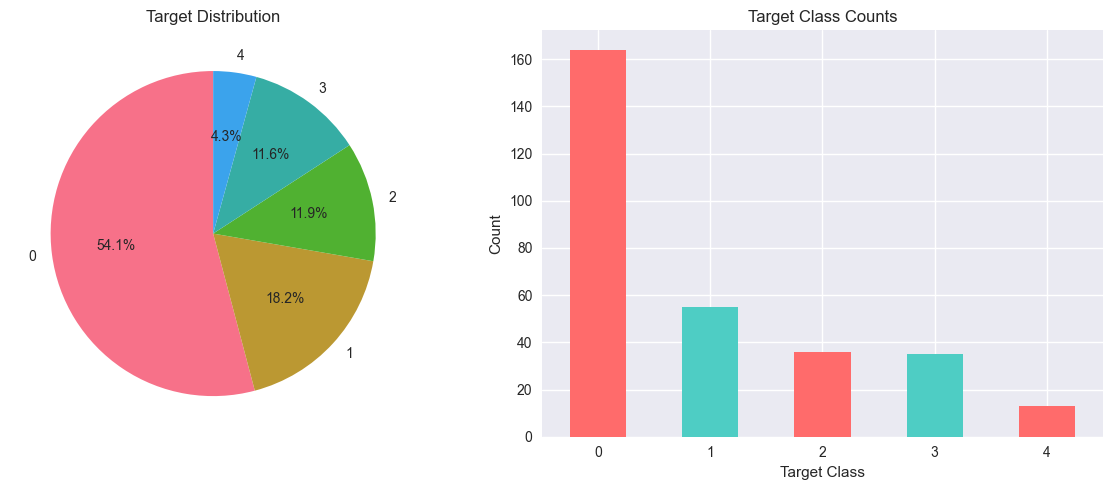

In [6]:
if df is not None:
    # Target distribution
    target_counts = df['target'].value_counts()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Pie chart
    ax1.pie(target_counts.values, labels=target_counts.index, autopct='%1.1f%%', startangle=90)
    ax1.set_title('Target Distribution')
    
    # Bar chart
    target_counts.plot(kind='bar', ax=ax2, color=['#ff6b6b', '#4ecdc4'])
    ax2.set_title('Target Class Counts')
    ax2.set_xlabel('Target Class')
    ax2.set_ylabel('Count')
    ax2.tick_params(axis='x', rotation=0)
    
    plt.tight_layout()
    plt.show()

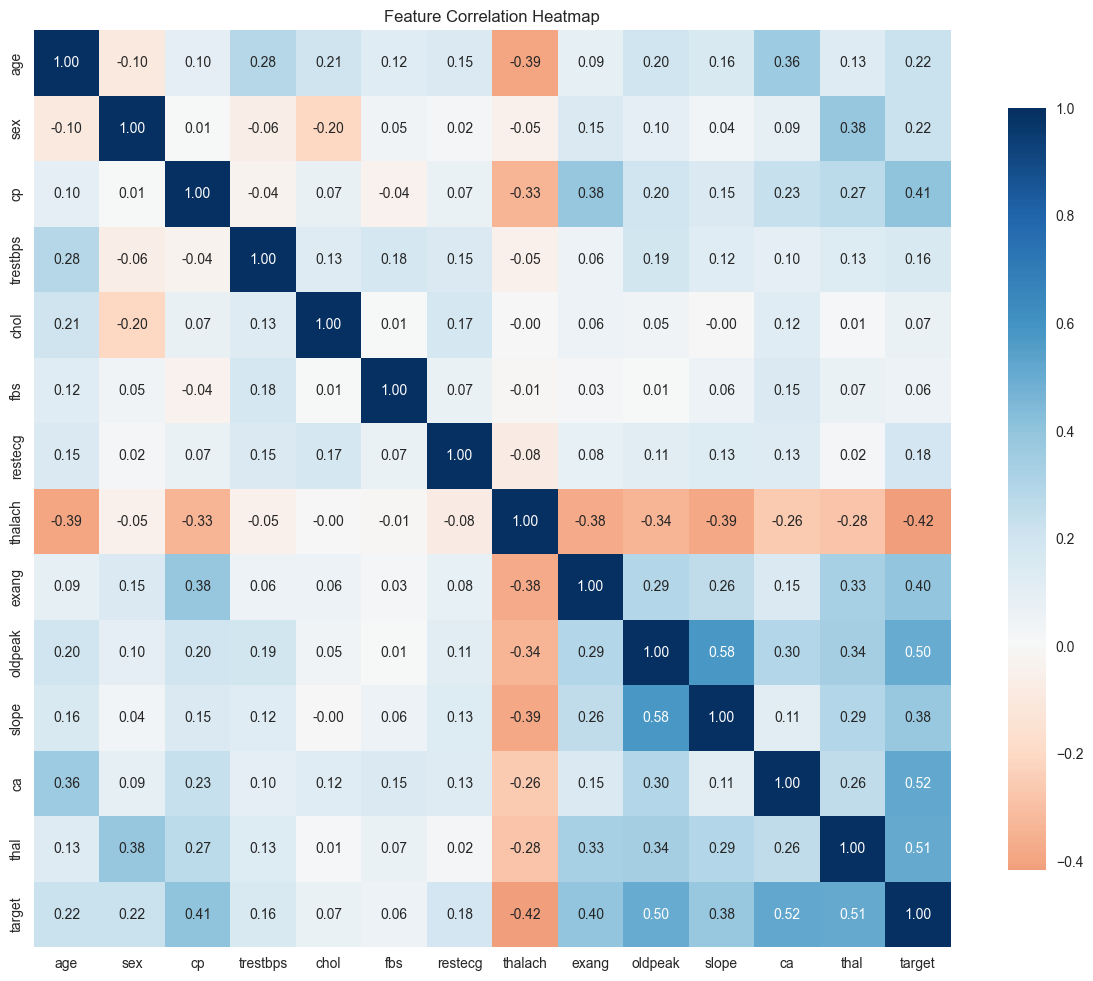

In [7]:
if df is not None:
    # Feature correlations
    correlation_matrix = df[numeric_cols].corr()
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='RdBu', center=0, 
                square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
    plt.title('Feature Correlation Heatmap')
    plt.tight_layout()
    plt.show()

## 5. Feature Engineering

Apply feature transformations and create new features.

In [8]:
def apply_feature_engineering(df):
    """Apply feature engineering transformations"""
    if df is None:
        return None
    
    print("Applying Feature Engineering...")
    
    # Handle missing values
    missing_before = df.isnull().sum().sum()
    if missing_before > 0:
        print(f"⚠️ Found {missing_before} missing values. Filling with median values for numerical columns.")
        df_clean = df.copy()
        numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
        df_clean[numeric_cols] = df_clean[numeric_cols].fillna(df_clean[numeric_cols].median())
    else:
        print("✅ No missing values found!")
        df_clean = df.copy()
    
    # Feature engineering: Create chol_age_ratio
    print("Creating new feature: Cholesterol-to-Age Ratio")
    
    if 'chol' in df_clean.columns and 'age' in df_clean.columns:
        df_clean['chol_age_ratio'] = df_clean['chol'] / df_clean['age']
        print("✅ Created 'chol_age_ratio' feature")
        
        print(f"Mean Ratio: {df_clean['chol_age_ratio'].mean():.2f}")
        print(f"Std Ratio: {df_clean['chol_age_ratio'].std():.2f}")
    else:
        print("❌ Required columns 'chol' and 'age' not found for feature engineering")
        return df_clean
    
    return df_clean

# Apply feature engineering
df_engineered = apply_feature_engineering(df)

Applying Feature Engineering...
⚠️ Found 6 missing values. Filling with median values for numerical columns.
Creating new feature: Cholesterol-to-Age Ratio
✅ Created 'chol_age_ratio' feature
Mean Ratio: 4.63
Std Ratio: 1.10


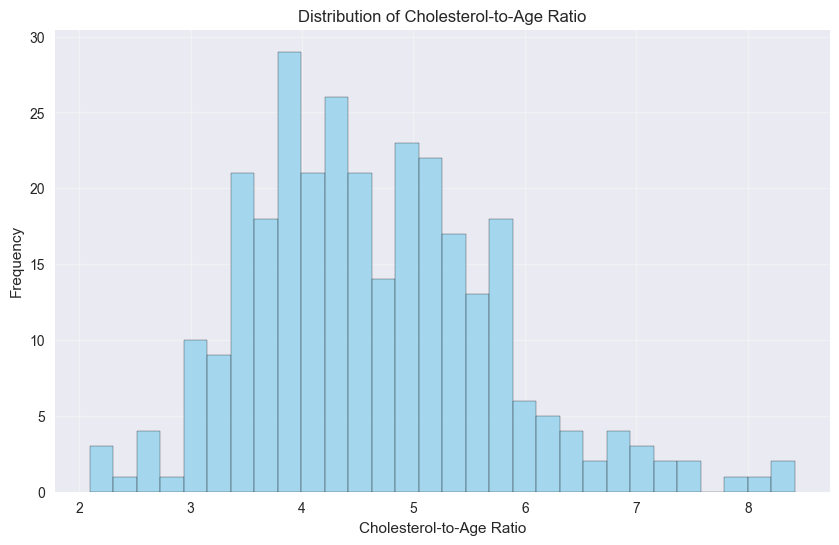

In [9]:
if df_engineered is not None and 'chol_age_ratio' in df_engineered.columns:
    # Visualize the new feature
    plt.figure(figsize=(10, 6))
    plt.hist(df_engineered['chol_age_ratio'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    plt.title('Distribution of Cholesterol-to-Age Ratio')
    plt.xlabel('Cholesterol-to-Age Ratio')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    plt.show()

## 6. Outlier Removal

Remove outliers based on quantile threshold.

In [10]:
def apply_outlier_removal(df, outlier_threshold=0.05):
    """Remove outliers based on quantile threshold"""
    if df is None:
        return None
    
    print("Applying Outlier Removal...")
    
    if 'chol_age_ratio' not in df.columns:
        print("❌ 'chol_age_ratio' column not found. Please apply feature engineering first.")
        return df
    
    # Calculate quantile threshold
    q_threshold = df['chol_age_ratio'].quantile(outlier_threshold)
    
    # Remove outliers
    df_filtered = df[df['chol_age_ratio'] >= q_threshold].copy()
    
    removed_count = len(df) - len(df_filtered)
    
    print(f"Original Samples: {len(df)}")
    print(f"Removed Outliers: {removed_count}")
    print(f"Remaining Samples: {len(df_filtered)}")
    
    if removed_count > 0:
        print(f"✅ Removed {removed_count} outliers (chol_age_ratio < {q_threshold:.2f})")
    else:
        print("ℹ️ No outliers removed with current threshold")
    
    return df_filtered

# Apply outlier removal
df_processed = apply_outlier_removal(df_engineered)

Applying Outlier Removal...
Original Samples: 303
Removed Outliers: 16
Remaining Samples: 287
✅ Removed 16 outliers (chol_age_ratio < 3.08)


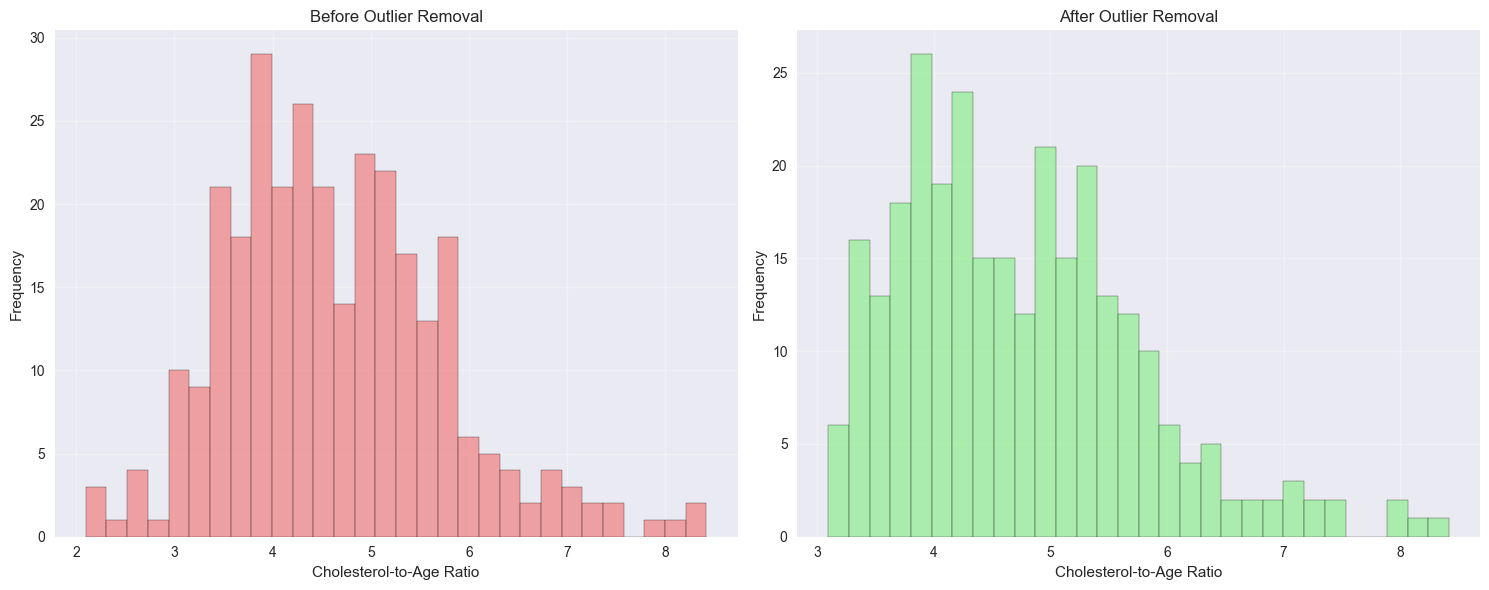

In [11]:
if df_engineered is not None and df_processed is not None and 'chol_age_ratio' in df_engineered.columns:
    # Visualize before and after outlier removal
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Before outlier removal
    ax1.hist(df_engineered['chol_age_ratio'], bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
    ax1.set_title('Before Outlier Removal')
    ax1.set_xlabel('Cholesterol-to-Age Ratio')
    ax1.set_ylabel('Frequency')
    ax1.grid(True, alpha=0.3)
    
    # After outlier removal
    ax2.hist(df_processed['chol_age_ratio'], bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
    ax2.set_title('After Outlier Removal')
    ax2.set_xlabel('Cholesterol-to-Age Ratio')
    ax2.set_ylabel('Frequency')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 7. Data Splitting

Create train, validation, and test splits with proper scaling.

In [12]:
def create_data_splits(df, train_size=0.7, val_size=0.15, test_size=0.15, random_state=42):
    """Create train, validation, and test splits"""
    if df is None:
        return None
    
    print("Creating Data Splits...")
    
    # Validate split sizes
    if abs(train_size + val_size + test_size - 1.0) > 0.001:
        print("❌ Split sizes must sum to 1.0")
        return None
    
    # Separate features and target
    X = df.drop('target', axis=1)
    y = df['target']
    
    # First split: train vs temp (val + test)
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, 
        test_size=(val_size + test_size), 
        random_state=random_state, 
        stratify=y
    )
    
    # Second split: validation vs test
    relative_test_size = test_size / (val_size + test_size)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, 
        test_size=relative_test_size, 
        random_state=random_state, 
        stratify=y_temp
    )
    
    # Display split information
    print(f"Training Set: {len(X_train)} samples ({len(X_train)/len(df)*100:.1f}%)")
    print(f"Validation Set: {len(X_val)} samples ({len(X_val)/len(df)*100:.1f}%)")
    print(f"Test Set: {len(X_test)} samples ({len(X_test)/len(df)*100:.1f}%)")
    
    # Scale the features
    print("Scaling Features...")
    scaler = StandardScaler()
    
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    # Convert back to DataFrames for easier handling
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
    X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
    
    print("✅ Data splitting and scaling completed!")
    
    return {
        'X_train': X_train_scaled, 'X_val': X_val_scaled, 'X_test': X_test_scaled,
        'y_train': y_train, 'y_val': y_val, 'y_test': y_test,
        'scaler': scaler
    }

# Create data splits
data_splits = create_data_splits(df_processed)

Creating Data Splits...
Training Set: 200 samples (69.7%)
Validation Set: 43 samples (15.0%)
Test Set: 44 samples (15.3%)
Scaling Features...
✅ Data splitting and scaling completed!


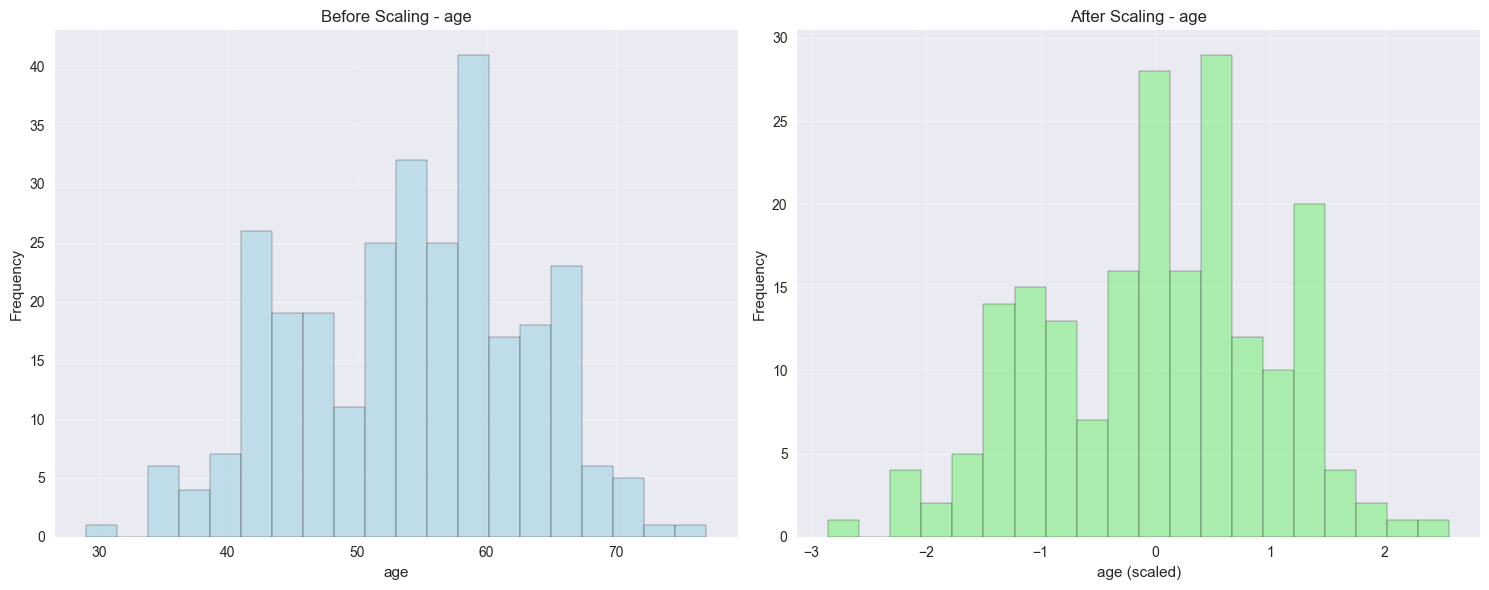

In [13]:
if data_splits is not None:
    # Show scaling effect on a sample feature
    feature_to_show = data_splits['X_train'].columns[0]  # First feature
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Before scaling (using original data)
    original_feature = df_processed.drop('target', axis=1)[feature_to_show]
    ax1.hist(original_feature, bins=20, alpha=0.7, color='lightblue', edgecolor='black')
    ax1.set_title(f'Before Scaling - {feature_to_show}')
    ax1.set_xlabel(feature_to_show)
    ax1.set_ylabel('Frequency')
    ax1.grid(True, alpha=0.3)
    
    # After scaling
    ax2.hist(data_splits['X_train'][feature_to_show], bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
    ax2.set_title(f'After Scaling - {feature_to_show}')
    ax2.set_xlabel(f'{feature_to_show} (scaled)')
    ax2.set_ylabel('Frequency')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 8. Model Training

Train a Decision Tree model with configurable parameters.

In [14]:
def train_model(data_splits, max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=42):
    """Train the Decision Tree model"""
    if data_splits is None:
        return None
    
    print("Training Model...")
    
    # Initialize model with parameters
    model = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=random_state
    )
    
    # Train the model
    model.fit(data_splits['X_train'], data_splits['y_train'])
    
    # Quick validation
    y_pred_val = model.predict(data_splits['X_val'])
    val_accuracy = accuracy_score(data_splits['y_val'], y_pred_val)
    
    print("✅ Model training completed successfully!")
    print(f"Model Type: Decision Tree Classifier")
    print(f"Training Samples: {len(data_splits['X_train'])}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    
    return model

# Train the model
model = train_model(data_splits)

Training Model...
✅ Model training completed successfully!
Model Type: Decision Tree Classifier
Training Samples: 200
Validation Accuracy: 0.5581


## 9. Model Evaluation

Comprehensive evaluation including accuracy metrics, confusion matrix, and feature importance.

In [15]:
def evaluate_model(model, data_splits):
    """Comprehensive model evaluation"""
    if model is None or data_splits is None:
        return None
    
    print("Evaluating Model...")
    
    # Make predictions
    y_pred_val = model.predict(data_splits['X_val'])
    y_pred_test = model.predict(data_splits['X_test'])
    
    # Calculate accuracies
    val_accuracy = accuracy_score(data_splits['y_val'], y_pred_val)
    test_accuracy = accuracy_score(data_splits['y_test'], y_pred_test)
    
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    
    # Confusion Matrix
    cm_test = confusion_matrix(data_splits['y_test'], y_pred_test)
    
    # Classification Report
    report = classification_report(
        data_splits['y_test'], 
        y_pred_test, 
        output_dict=True
    )
    
    # Feature Importance
    feature_importance = pd.DataFrame({
        'feature': data_splits['X_train'].columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    return {
        'val_accuracy': val_accuracy,
        'test_accuracy': test_accuracy,
        'confusion_matrix': cm_test,
        'classification_report': report,
        'feature_importance': feature_importance
    }

# Evaluate the model
model_results = evaluate_model(model, data_splits)

Evaluating Model...
Validation Accuracy: 0.5581
Test Accuracy: 0.4773


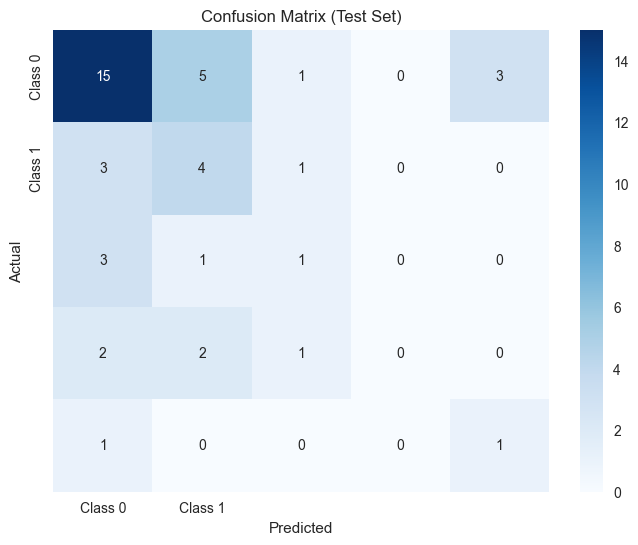

In [16]:
if model_results is not None:
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(model_results['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
                xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.title('Confusion Matrix (Test Set)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [17]:
if model_results is not None:
    # Classification report
    print("Classification Report:")
    report_df = pd.DataFrame(model_results['classification_report']).transpose()
    display(report_df)

Classification Report:


,precision,recall,f1-score,support
0,0.625000,0.625000,0.625000,24.000000
1,0.333333,0.500000,0.400000,8.000000
2,0.250000,0.200000,0.222222,5.000000
3,0.000000,0.000000,0.000000,5.000000
4,0.250000,0.500000,0.333333,2.000000
accuracy,0.477273,0.477273,0.477273,0.477273
macro avg,0.291667,0.365000,0.316111,44.000000
weighted avg,0.441288,0.477273,0.454040,44.000000


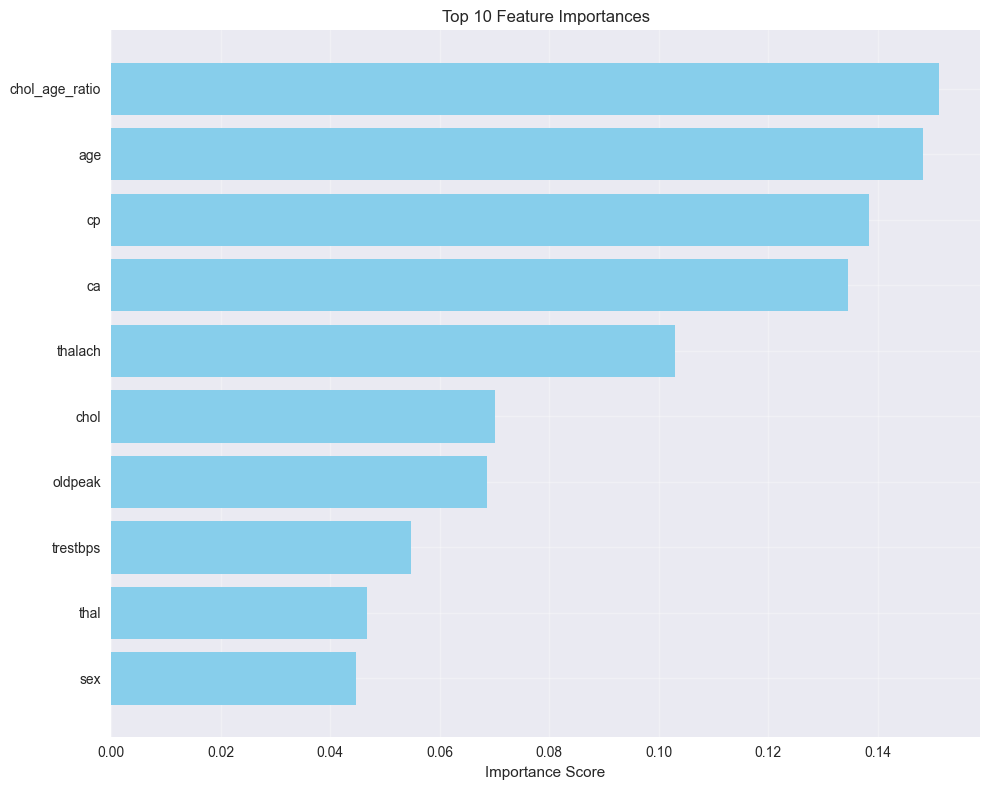

In [18]:
if model_results is not None:
    # Feature importance
    top_features = model_results['feature_importance'].head(10)
    
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(top_features)), top_features['importance'], color='skyblue')
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Importance Score')
    plt.title('Top 10 Feature Importances')
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## 10. Making Predictions

Test the model with sample data and make predictions.

In [19]:
def make_sample_prediction(model, data_splits, sample_idx=0):
    """Make prediction on a sample from test set"""
    if model is None or data_splits is None:
        return None
    
    # Select sample from test set
    sample_data = data_splits['X_test'].iloc[sample_idx]
    true_label = data_splits['y_test'].iloc[sample_idx]
    
    # Make prediction
    prediction = model.predict(sample_data.values.reshape(1, -1))[0]
    prediction_proba = model.predict_proba(sample_data.values.reshape(1, -1))[0]
    
    # Display results
    print(f"Sample {sample_idx + 1} Prediction Results:")
    print(f"True Label: {int(true_label)}")
    print(f"Predicted Label: {int(prediction)}")
    print(f"Result: {'✅ Correct' if prediction == true_label else '❌ Incorrect'}")
    print(f"Prediction Probabilities: {prediction_proba}")
    print(f"Confidence: {max(prediction_proba):.3f}")
    
    # Display sample input data
    print("\nSample Input Data:")
    sample_df = pd.DataFrame(sample_data).T
    display(sample_df)
    
    return {
        'sample_data': sample_data,
        'true_label': true_label,
        'prediction': prediction,
        'prediction_proba': prediction_proba
    }

# Make sample predictions
if model is not None and data_splits is not None:
    print("Making sample predictions from test set:")
    print("=" * 50)
    
    # Test first 3 samples
    for i in range(min(3, len(data_splits['X_test']))):
        result = make_sample_prediction(model, data_splits, i)
        print("\n" + "-" * 50 + "\n")

Making sample predictions from test set:
Sample 1 Prediction Results:
True Label: 3
Predicted Label: 1
Result: ❌ Incorrect
Prediction Probabilities: [0. 1. 0. 0. 0.]
Confidence: 1.000

Sample Input Data:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,chol_age_ratio
97,0.642767,-1.603567,0.881942,1.050072,0.145392,-0.411814,0.948815,0.30391,-0.725753,1.554194,0.66494,1.40133,1.161388,-0.386255



--------------------------------------------------

Sample 2 Prediction Results:
True Label: 4
Predicted Label: 4
Result: ✅ Correct
Prediction Probabilities: [0. 0. 0. 0. 1.]
Confidence: 1.000

Sample Input Data:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,chol_age_ratio
174,1.093435,0.62361,0.881942,0.769004,-0.742794,-0.411814,0.948815,-0.790078,-0.725753,0.996135,0.66494,1.40133,0.64636,-1.356983



--------------------------------------------------

Sample 3 Prediction Results:
True Label: 3
Predicted Label: 0
Result: ❌ Incorrect
Prediction Probabilities: [1. 0. 0. 0. 0.]
Confidence: 1.000

Sample Input Data:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,chol_age_ratio
180,-0.70924,0.62361,0.881942,-0.411484,0.454327,-0.411814,0.948815,0.697745,-0.725753,-0.399012,0.66494,-0.738105,1.161388,0.998159



--------------------------------------------------



Sample 1 Prediction Results:
True Label: 3
Predicted Label: 1
Result: ❌ Incorrect
Prediction Probabilities: [0. 1. 0. 0. 0.]
Confidence: 1.000

Sample Input Data:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,chol_age_ratio
97,0.642767,-1.603567,0.881942,1.050072,0.145392,-0.411814,0.948815,0.30391,-0.725753,1.554194,0.66494,1.40133,1.161388,-0.386255


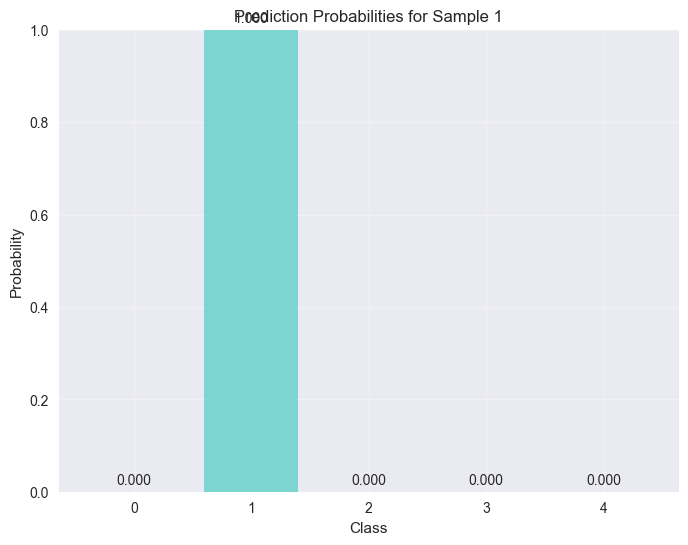

In [20]:
if model is not None and data_splits is not None:
    # Visualize prediction probabilities for a sample
    sample_result = make_sample_prediction(model, data_splits, 0)
    
    if sample_result is not None:
        classes = model.classes_
        probabilities = sample_result['prediction_proba']
        
        plt.figure(figsize=(8, 6))
        bars = plt.bar(classes, probabilities, color=['#ff6b6b', '#4ecdc4'], alpha=0.7)
        plt.xlabel('Class')
        plt.ylabel('Probability')
        plt.title('Prediction Probabilities for Sample 1')
        plt.ylim(0, 1)
        
        # Add value labels on bars
        for bar, prob in zip(bars, probabilities):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                    f'{prob:.3f}', ha='center', va='bottom')
        
        plt.grid(True, alpha=0.3)
        plt.show()

## 11. Save Experiment Results (Optional)

Save experiment results to database for tracking and comparison.

In [21]:
def save_experiment_results(db_session, df, data_splits, model, model_results):
    """Save experiment results to database"""
    if db_session is None:
        print("Database session not available. Skipping save.")
        return None
    
    try:
        model_params = {
            'max_depth': getattr(model, 'max_depth', None),
            'min_samples_split': getattr(model, 'min_samples_split', 2),
            'min_samples_leaf': getattr(model, 'min_samples_leaf', 1),
            'random_state': getattr(model, 'random_state', None)
        }
        
        experiment = ExperimentRun(
            dataset_samples=len(df),
            train_samples=len(data_splits['X_train']),
            val_samples=len(data_splits['X_val']),
            test_samples=len(data_splits['X_test']),
            val_accuracy=model_results['val_accuracy'],
            test_accuracy=model_results['test_accuracy'],
            model_params=json.dumps(model_params),
            feature_importance=json.dumps(model_results['feature_importance'].to_dict('records'))
        )
        
        db_session.add(experiment)
        db_session.commit()
        
        print(f"✅ Experiment saved with ID: {experiment.id}")
        return experiment.id
    except Exception as e:
        print(f"Failed to save experiment: {str(e)}")
        db_session.rollback()
        return None

# Save experiment results
if (db_session is not None and model is not None and 
    model_results is not None and data_splits is not None):
    experiment_id = save_experiment_results(db_session, df_processed, data_splits, model, model_results)
else:
    print("Skipping experiment save - missing requirements or database not available")

Skipping experiment save - missing requirements or database not available


## 12. Summary Report

Generate a comprehensive summary of the ML pipeline results.

In [22]:
def generate_summary_report(df, model_results, data_splits):
    """Generate a comprehensive summary report"""
    if df is None or model_results is None or data_splits is None:
        print("Cannot generate report - missing data")
        return
    
    print("=" * 60)
    print("           HEART DISEASE PREDICTION ML PIPELINE")
    print("                    SUMMARY REPORT")
    print("=" * 60)
    print()
    
    print("📊 DATASET SUMMARY")
    print("-" * 30)
    print(f"Total Samples: {len(df)}")
    print(f"Features: {len(df.columns) - 1}")
    print(f"Target Classes: {df['target'].nunique()}")
    print(f"Missing Values: {df.isnull().sum().sum()}")
    print()
    
    print("📈 MODEL PERFORMANCE")
    print("-" * 30)
    print(f"Validation Accuracy: {model_results['val_accuracy']:.4f}")
    print(f"Test Accuracy: {model_results['test_accuracy']:.4f}")
    print()
    
    print("📋 DATA SPLITS")
    print("-" * 30)
    total_samples = len(data_splits['X_train']) + len(data_splits['X_val']) + len(data_splits['X_test'])
    print(f"Training: {len(data_splits['X_train'])} ({len(data_splits['X_train'])/total_samples*100:.1f}%)")
    print(f"Validation: {len(data_splits['X_val'])} ({len(data_splits['X_val'])/total_samples*100:.1f}%)")
    print(f"Test: {len(data_splits['X_test'])} ({len(data_splits['X_test'])/total_samples*100:.1f}%)")
    print()
    
    print("🎯 TOP 5 IMPORTANT FEATURES")
    print("-" * 30)
    for i, (_, row) in enumerate(model_results['feature_importance'].head(5).iterrows(), 1):
        print(f"{i}. {row['feature']}: {row['importance']:.4f}")
    print()
    
    print("✅ PIPELINE COMPLETED SUCCESSFULLY!")
    print("=" * 60)

# Generate summary report
if df_processed is not None and model_results is not None and data_splits is not None:
    generate_summary_report(df_processed, model_results, data_splits)

           HEART DISEASE PREDICTION ML PIPELINE
                    SUMMARY REPORT

📊 DATASET SUMMARY
------------------------------
Total Samples: 287
Features: 14
Target Classes: 5
Missing Values: 0

📈 MODEL PERFORMANCE
------------------------------
Validation Accuracy: 0.5581
Test Accuracy: 0.4773

📋 DATA SPLITS
------------------------------
Training: 200 (69.7%)
Validation: 43 (15.0%)
Test: 44 (15.3%)

🎯 TOP 5 IMPORTANT FEATURES
------------------------------
1. chol_age_ratio: 0.1512
2. age: 0.1483
3. cp: 0.1385
4. ca: 0.1347
5. thalach: 0.1030

✅ PIPELINE COMPLETED SUCCESSFULLY!


## Conclusion

This notebook implemented a complete machine learning pipeline for heart disease prediction, including:

1. **Data Loading**: UCI Heart Disease dataset
2. **Data Exploration**: Descriptive statistics and visualizations
3. **Feature Engineering**: Created cholesterol-to-age ratio feature
4. **Data Preprocessing**: Outlier removal and data splitting
5. **Model Training**: Decision Tree classifier
6. **Model Evaluation**: Comprehensive performance metrics
7. **Predictions**: Interactive prediction capabilities
8. **Experiment Tracking**: Optional database storage for results

The pipeline provides a solid foundation for heart disease prediction and can be extended with additional features, different algorithms, or hyperparameter tuning for improved performance.